# Import modules

In [134]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

# Sales

## Import

In [135]:
import pandas as pd
import numpy as np

#read in sales data, already subsetted to include Manhattan only
sales17 = pd.read_csv("INPUT_nycod/2017_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales18 = pd.read_csv("INPUT_nycod/2018_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales19 = pd.read_csv("INPUT_nycod/2019_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales20 = pd.read_csv("INPUT_nycod/2020_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales21 = pd.read_csv("INPUT_nycod/2021_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales22 = pd.read_csv("INPUT_nycod/rollingsales_manhattan.csv", skiprows=1, header=None).dropna(how='all')

#concatenate all dfs, check shape
allsales = pd.concat((sales17, sales18, sales19, sales20, sales21, sales22), axis=0)
allsales = allsales.iloc[:,0:21]
print(allsales.shape)

#add labels
labels = pd.DataFrame(pd.read_csv("INPUT_nycod/2021_manhattan.csv", header=6).columns).T
allsales = pd.concat((labels, allsales), axis=0)
allsales.columns = allsales.iloc[0] 
sales = allsales[1:]
sales.columns

(110226, 21)


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL\nUNITS', 'COMMERCIAL\nUNITS', 'TOTAL \nUNITS',
       'LAND \nSQUARE FEET', 'GROSS \nSQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS\nAT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object', name=0)

## Select cols for subsetting

In [136]:
sales = sales[['BLOCK',
                'LOT',
                'ADDRESS',
                'RESIDENTIAL\nUNITS',
                'COMMERCIAL\nUNITS',
                'LAND \nSQUARE FEET',
                'GROSS \nSQUARE FEET',
                'YEAR BUILT',
                'SALE DATE',
                'SALE PRICE']]

#rename columns for interpretability
col_mapper = {'RESIDENTIAL\nUNITS':'units_residential',
             'COMMERCIAL\nUNITS':'units_commercial',
             'BLOCK': 'block_sales',
             'LOT': 'lot_sales',
             'ADDRESS': 'address_sales'}
sales = sales.rename(mapper=col_mapper, axis=1)

sales.shape

(110226, 10)

## Dtype handling

In [137]:
sales.dtypes

0
block_sales            object
lot_sales              object
address_sales          object
units_residential      object
units_commercial       object
LAND \nSQUARE FEET     object
GROSS \nSQUARE FEET    object
YEAR BUILT             object
SALE DATE              object
SALE PRICE             object
dtype: object

In [138]:
#clean sale price
prices = []
for i in sales['SALE PRICE']:
    prices.append(float(i.replace(",", "").replace("'", "").replace("$", "")))
sales['saleprice'] = prices

#clean sale date -> year sold, years elapsed
import datetime
dates = []
for i in sales['SALE DATE']:
    dates.append(datetime.datetime.strptime(i, "%m/%d/%Y"))
sales['saledate'] = dates
years = []
for i in sales['SALE DATE']:
    years.append(int(i[-4:]))
sales['year_sold'] = years
sales['years_elapsed'] = sales.year_sold - sales['YEAR BUILT']

#calculate FAR
gross_sqft = []
for i in sales['GROSS \nSQUARE FEET']:
    try:
        gross_sqft.append(int(i.replace(",", "").replace("'", "").replace("-", "").replace(" ", "")))
    except:
        gross_sqft.append(0)
sales['gross_sqft'] = gross_sqft
land_sqft = []
for i in sales['LAND \nSQUARE FEET']:
    try:
        land_sqft.append(int(i.replace(",", "").replace("'", "").replace("-", "").replace(" ", "")))
    except:
        land_sqft.append(0)
sales['land_sqft'] = land_sqft
sales['FAR'] = sales['gross_sqft'] / sales['land_sqft']

#change dtypes
sales.block_sales = sales.block_sales.astype(np.int64)
sales.lot_sales = sales.lot_sales.astype(np.int64)
sales.units_commercial = pd.to_numeric(sales.units_commercial.replace(',',''), errors='coerce')
sales.units_residential = pd.to_numeric(sales.units_residential.replace(',',''), errors='coerce')

#drop columns only used for calc
sales = sales.drop(columns=['SALE PRICE',
                           'YEAR BUILT',
                           'SALE DATE',
                           'GROSS \nSQUARE FEET',
                           'LAND \nSQUARE FEET',
                           'gross_sqft',
                           'land_sqft',
                           'saledate'])
sales.columns

Index(['block_sales', 'lot_sales', 'address_sales', 'units_residential',
       'units_commercial', 'saleprice', 'year_sold', 'years_elapsed', 'FAR'],
      dtype='object', name=0)

## Visualize rows to be dropped: sale price == 0, res units == NaN

total observations: 110226
non-sale transfers (sale price 0): 21787
sales (sale price > 0): 88439


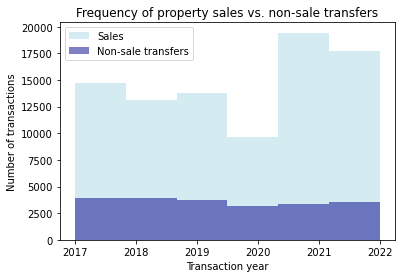

In [139]:
#FOR VIZ ONLY
#missing sale price
print("total observations: {}".format(len(sales)))
print("non-sale transfers (sale price 0): {}".format(len(sales[sales['saleprice'] == 0])))
print("sales (sale price > 0): {}".format(len(sales[sales['saleprice'] > 0])))

import matplotlib.pyplot as plt
plt.hist(sales[sales.saleprice > 0].year_sold, alpha=0.5, color='lightblue', label='Sales', bins=6)
plt.hist(sales[sales.saleprice == 0].year_sold, alpha=0.5, color='darkblue', label='Non-sale transfers', bins=6)
plt.legend()
plt.title('Frequency of property sales vs. non-sale transfers')
plt.xlabel('Transaction year')
plt.ylabel('Number of transactions')
plt.savefig('OUTPUT_visualizations/1.Sales vs. non-sale transfers.png')
plt.show()

In [140]:
#SUBSET DATA
sales = sales[sales['saleprice'] > 1]

#after removing zeros
sales['log_saleprice'] = np.log(sales.saleprice)
sales = sales.drop(columns=['saleprice'])

In [141]:
sales.shape

(88224, 9)

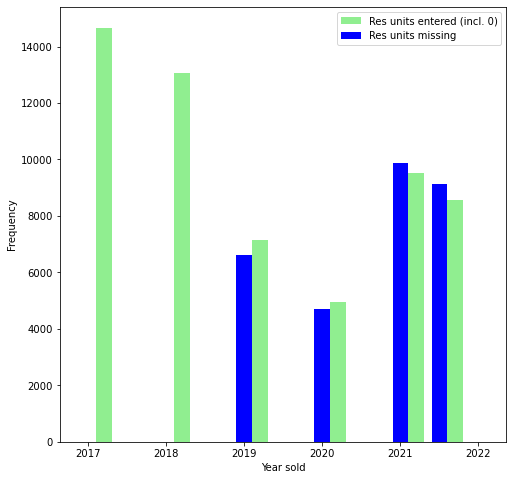

In [142]:
#FOR VIZ ONLY
#dates of missing and nonmissing residential units

a = sales[sales['units_residential']>=-1]
b = sales[sales['units_residential'].isna() == True]

plt.figure(figsize=(8,8))
plt.hist(a.year_sold+0.1, label='Res units entered (incl. 0)', color='lightgreen', width=0.2)
plt.hist(b.year_sold-0.1, label='Res units missing', color='blue', width=0.2)
plt.xlabel('Year sold')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('OUTPUT_visualizations/resunitsmissing.png')
plt.show()

# PLUTO

## Import

In [143]:
pluto = pd.read_csv("INPUT_pluto/pluto_22v3_1.csv", low_memory=False)
pluto.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

## Select cols for subsetting

In [144]:
#subset to include Manhattan only
pluto = pluto[pluto['borough']=='MN']
pluto = pluto[['block',
              'lot',
               'address',
               'ltdheight',
              'splitzone',
              'histdist',
              'landmark',
              'bldgarea',
              'lotarea',
              'latitude',
              'longitude',
              'yearalter1',
              'yearalter2',
              'numbldgs',
              'numfloors']]

#rename columns for interpretability
col_mapper = {'block': 'block_pluto',
             'lot': 'lot_pluto',
             'address': 'address_pluto'}
pluto = pluto.rename(mapper=col_mapper, axis=1)

In [40]:
pluto.shape

(42695, 15)

## Dtype handling

In [145]:
#create BCR variable
pluto['BCR'] = pluto['bldgarea'] / pluto['lotarea']

#create binary variables
bin_cols = ['ltdheight', 'splitzone', 'histdist', 'landmark']
pluto['bin_ltdheight'] = abs(1-(pluto.ltdheight.isna()))
pluto['bin_splitzone'] = abs(1-(pluto.splitzone.isna()))
pluto['bin_histdist'] = abs(1-(pluto.histdist.isna()))
pluto['bin_landmark'] = abs(1-(pluto.landmark.isna()))

#drop cols only used for calc
pluto = pluto.drop(columns=['bldgarea',
                           'lotarea',
                           'ltdheight',
                           'histdist',
                           'landmark',
                           'splitzone'])
pluto.columns

Index(['block_pluto', 'lot_pluto', 'address_pluto', 'latitude', 'longitude',
       'yearalter1', 'yearalter2', 'numbldgs', 'numfloors', 'BCR',
       'bin_ltdheight', 'bin_splitzone', 'bin_histdist', 'bin_landmark'],
      dtype='object')

# Merge sales and pluto

In [146]:
pluto = pluto[pluto.block_pluto < pluto.block_pluto.max()]

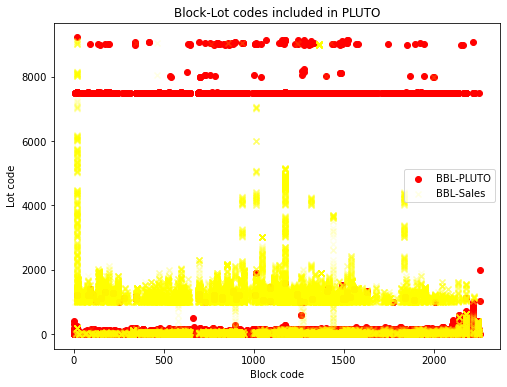

In [147]:
# Merge NYCOD and PLUTO
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(pluto.block_pluto, pluto.lot_pluto, label='BBL-PLUTO', color='red')
plt.scatter(sales.block_sales, sales.lot_sales, label='BBL-Sales', color='yellow', alpha=0.1, marker='x')
plt.xlabel('Block code')
plt.ylabel('Lot code')
plt.title('Block-Lot codes included in PLUTO')
plt.legend()
plt.savefig('OUTPUT_visualizations/3.Borough-Lot coverage.png')
plt.show()

In [148]:
# join based on BBL
df_1 = sales.merge(pluto, how='left', left_on=['block_sales', 'lot_sales'], right_on=['block_pluto', 'lot_pluto'])

#join based on address
#isolate transactions that were not matched before
missed = df_1[df_1['latitude'].isna() == True].iloc[:,:10]
#clean address text
addresses = []
for i in missed.address_sales:
    addresses.append(i.split(',')[0])
missed['address_clean'] = addresses
#merge on address
df_2 = missed.merge(pluto, how='left', left_on=['address_clean'], right_on=['address_pluto'])

#save out unmatched cells for later
unmatched_df = df_2[df_2.latitude.isna() == True].drop(columns=['address_clean', 'address_sales', 'address_pluto'])

#quantify
df_1 = df_1[df_1.latitude.isna() == False].drop(columns=['address_sales', 'address_pluto'])
df_2 = df_2[df_2.latitude.isna() == False].drop(columns=['address_clean', 'address_sales', 'address_pluto'])

len_all = len(sales)
len_bbl = len(df_1)
len_add = len(df_2)

print('{} total sales'.format(len_all))
print('{} matched on BBL'.format(len_bbl))
print('{} matched on address'.format(len_add))
print('{} unmatched ({:.3f}% of total)'.format((len_all - len_bbl - len_add), (100*(len_all - len_bbl - len_add)/len_all)))

#final df
df = pd.concat((df_1, df_2), axis=0)
df = df.drop(columns=['block_sales', 'lot_sales', 'block_pluto', 'lot_pluto'])
df.columns.sort_values()
#drop empty
df = df.dropna(how='all', axis=1)
df = df.dropna(how='all', axis=0)
print('shape of final df: {}'.format(df.shape))

df.to_csv('OUTPUT_cleandata/df_clean.csv')

88224 total sales
43666 matched on BBL
18471 matched on address
26087 unmatched (29.569% of total)
shape of final df: (62137, 19)


In [150]:
df = df.drop(columns=['block_pluto_x', 'block_pluto_y'])

In [151]:
unmatched_df = unmatched_df.drop(columns=['block_pluto_x', 'block_pluto_y', 'block_sales', 'lot_sales'])

In [152]:
unmatched_df = unmatched_df.drop(columns=['block_sales', 'lot_sales'])

KeyError: "['block_sales', 'lot_sales'] not found in axis"

In [153]:
unmatched_df = unmatched_df.drop(columns=['lot_pluto'])

In [154]:
unmatched_df.columns

Index(['units_residential', 'units_commercial', 'year_sold', 'years_elapsed',
       'FAR', 'log_saleprice', 'latitude', 'longitude', 'yearalter1',
       'yearalter2', 'numbldgs', 'numfloors', 'BCR', 'bin_ltdheight',
       'bin_splitzone', 'bin_histdist', 'bin_landmark'],
      dtype='object')

In [155]:
len(unmatched_df.columns)

17

In [156]:
df.describe().T['mean']

units_residential       3.603159
units_commercial        0.782051
year_sold            2019.854708
FAR                          inf
log_saleprice          14.038757
latitude               40.763037
longitude             -73.976283
yearalter1            994.693382
yearalter2            123.623906
numbldgs                1.349339
numfloors              16.190418
BCR                     8.849303
bin_ltdheight           0.019924
bin_splitzone           0.963854
bin_histdist            0.266299
bin_landmark            0.028872
Name: mean, dtype: float64

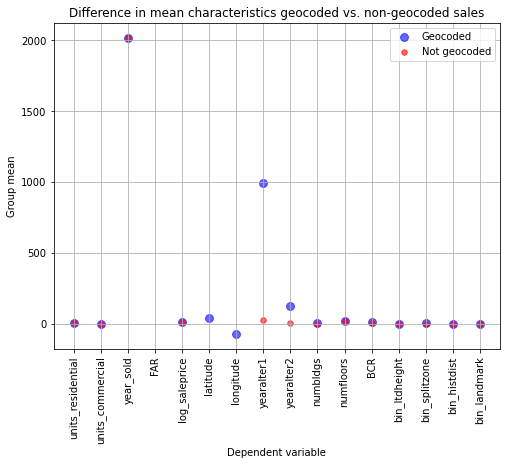

In [160]:
#compare df and unmatched_df

num_cols = ['units_residential', 'units_commercial', 'year_sold',
       'FAR', 'log_saleprice', 'latitude', 'longitude', 'yearalter1',
       'yearalter2', 'numbldgs', 'numfloors', 'BCR', 'bin_ltdheight',
       'bin_splitzone', 'bin_histdist', 'bin_landmark']

plt.figure(figsize=(8, 6))
plt.scatter(num_cols, df.describe().T['mean'], label='Geocoded', color='blue', s=len(df)/1000, alpha=0.6)
plt.scatter(num_cols, unmatched_df.describe().T['mean'], label='Not geocoded', color='red', s=len(unmatched_df)/1000, alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel('Dependent variable')
plt.ylabel('Group mean')
plt.legend()
plt.grid()
plt.title('Difference in mean characteristics geocoded vs. non-geocoded sales')
plt.savefig('OUTPUT_visualizations/nongeocoded.png')
plt.show()

In [158]:
print(df.shape)
df.columns

(62137, 17)


Index(['units_residential', 'units_commercial', 'year_sold', 'years_elapsed',
       'FAR', 'log_saleprice', 'latitude', 'longitude', 'yearalter1',
       'yearalter2', 'numbldgs', 'numfloors', 'BCR', 'bin_ltdheight',
       'bin_splitzone', 'bin_histdist', 'bin_landmark'],
      dtype='object')

# Merge in distance datasets

In [19]:
import pandas as pd

hospital = pd.read_csv('INPUT_distances/hospital.csv')
park = pd.read_csv('INPUT_distances/park.csv')
school = pd.read_csv('INPUT_distances/public_school.csv')
subway = pd.read_csv('INPUT_distances/subway.csv')
housing = pd.read_csv('INPUT_distances/affordable_housing.csv')
college = pd.read_csv('INPUT_distances/college_university.csv')
museum = pd.read_csv('INPUT_distances/museum.csv')

df['dist_park'] = park.distance.values[:len(df)]
df['dist_subway'] = subway.distance.values[:len(df)]
df['dist_hospital'] = hospital.distance.values[:len(df)]
df['dist_school'] = school.distance.values[:len(df)]
df['dist_housingdev'] = housing.distance.values[:len(df)]
df['dist_college'] = college.distance.values[:len(df)]
df['dist_museum'] = museum.distance.values[:len(df)]

In [161]:
#visualize distribution of each 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(df.dist_hospital, df.log_saleprice, color='pink', alpha=0.3, label='Distance to hospital')
plt.scatter(df.dist_college, df.log_saleprice, color='purple', alpha=0.3, label='Distance to college or university')
plt.scatter(df.dist_museum, df.log_saleprice, color='gray', alpha=0.3, label='Distance to museum')
plt.scatter(df.dist_housingdev, df.log_saleprice, color='blue', alpha=0.3, label='Distance to affordable housing')
plt.scatter(df.dist_subway, df.log_saleprice, color='orange', alpha=0.3, label='Distance to subway')
plt.scatter(df.dist_school, df.log_saleprice, color='yellow', alpha=0.3, label='Distance to school')
plt.scatter(df.dist_park, df.log_saleprice, color='green', alpha=0.3, label='Distance to park')
plt.xlabel('Distance measure')
plt.ylabel('Log of sale price')
plt.legend()
plt.savefig('OUTPUT_visualizations/distances.png')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'dist_hospital'

<Figure size 864x576 with 0 Axes>

In [22]:
#check out columns with a lot of missing data
cols = pd.DataFrame(df.columns).rename(columns={0:'column_name'})
missing = []
for i in cols['column_name']:
    missing.append(100*df[i].isnull().sum()/len(df[i]))
cols['pct_missing'] = missing
to_drop = []
for i in cols.index:
    if cols['pct_missing'][i] > 90:
        to_drop.append(cols['column_name'][i])
df = df.drop(columns=to_drop)

print('Features with > 90% missing data: {} \n'.format(to_drop))
print('Features with any missing data:')
display(cols[cols['pct_missing']>0].sort_values('pct_missing', ascending=False))

Features with > 90% missing data: [] 

Features with any missing data:


,column_name,pct_missing
1,units_commercial,58.235834
0,units_residential,44.055877
10,numfloors,4.597905
3,years_elapsed,3.934854
11,BCR,3.603328
9,numbldgs,3.505158
7,yearalter1,0.001609
8,yearalter2,0.001609


In [23]:
df.shape

(62137, 23)

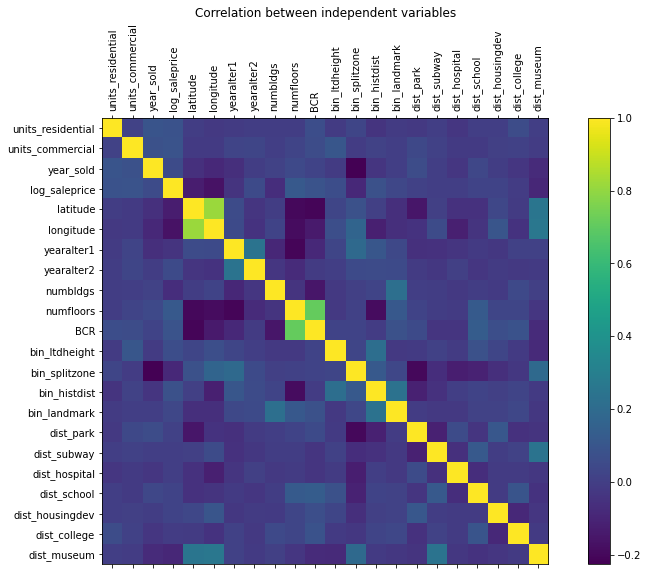

In [24]:
# plot corr matrix of all vars

f = plt.figure(figsize=(14, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation between independent variables')
plt.savefig('OUTPUT_visualizations/4.Corr matrix for all vars.png')
plt.show()

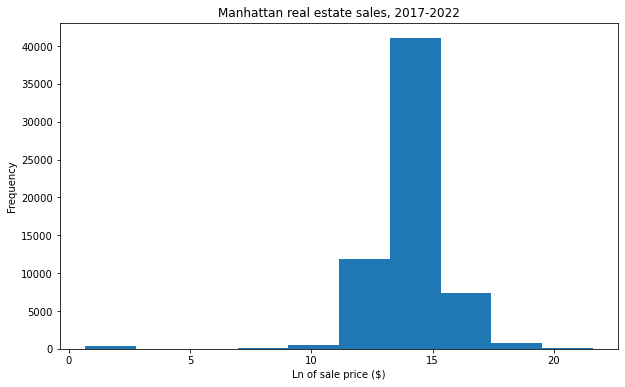

In [25]:
#plot hist of sale prices

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['log_saleprice'])
plt.xlabel('Ln of sale price')
plt.ylabel('Frequency')
plt.title('Manhattan real estate sales, 2017-2022')
plt.savefig('OUTPUT_visualizations/5.Histogram of ln sale price.png')
plt.show()

In [26]:
df.describe().T.reset_index().sort_values(by='index').rename(columns={'index':'column_name'})

,column_name,count,mean,std,min,25%,50%,75%,max
10,BCR,59898.0,8.849303,5.140569,0.000000,4.353262,8.112054,12.133492,52.951082
13,bin_histdist,62137.0,0.266299,0.442026,0.000000,0.000000,0.000000,1.000000,1.000000
14,bin_landmark,62137.0,0.028872,0.167447,0.000000,0.000000,0.000000,0.000000,1.000000
11,bin_ltdheight,62137.0,0.019924,0.139739,0.000000,0.000000,0.000000,0.000000,1.000000
12,bin_splitzone,62137.0,0.963854,0.186655,0.000000,1.000000,1.000000,1.000000,1.000000
20,dist_college,62137.0,0.006266,0.003799,0.000001,0.003205,0.005641,0.008870,0.019470
17,dist_hospital,62137.0,0.014633,0.008621,0.000209,0.008622,0.012274,0.018683,0.039067
19,dist_housingdev,62137.0,0.003039,0.002137,0.000111,0.001379,0.002769,0.004141,0.012611
21,dist_museum,62137.0,0.004895,0.002905,0.000004,0.002542,0.004476,0.006992,0.018043
15,dist_park,62137.0,0.001567,0.001143,0.000000,0.000629,0.001268,0.002176,0.006403


In [27]:
df.to_csv('OUTPUT_cleandata/df_dist.csv')

In [162]:
df.describe()

,units_residential,units_commercial,year_sold,FAR,log_saleprice,latitude,longitude,yearalter1,yearalter2,numbldgs,numfloors,BCR,bin_ltdheight,bin_splitzone,bin_histdist,bin_landmark
count,34762.000000,25951.000000,62137.000000,5929.000000,62137.000000,62137.000000,62137.000000,62136.000000,62136.000000,59959.000000,59280.000000,59898.000000,62137.000000,62137.000000,62137.000000,62137.000000
mean,3.603159,0.782051,2019.854708,inf,14.038757,40.763037,-73.976283,994.693382,123.623906,1.349339,16.190418,8.849303,0.019924,0.963854,0.266299,0.028872
std,22.365354,8.905739,1.792338,NaN,1.487696,0.033522,0.021194,995.871740,482.424964,2.144255,12.555822,5.140569,0.139739,0.186655,0.442026,0.167447
min,0.000000,0.000000,2017.000000,0.000000,0.693147,40.702776,-74.018118,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2018.000000,2.220779,13.345507,40.737678,-73.993629,0.000000,0.000000,1.000000,6.000000,4.353262,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,2020.000000,3.381857,13.952730,40.763190,-73.978224,0.000000,0.000000,1.000000,14.000000,8.112054,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,2021.000000,4.407817,14.731801,40.780596,-73.959475,1987.000000,0.000000,1.000000,20.000000,12.133492,0.000000,1.000000,1.000000,0.000000
max,899.000000,570.000000,2022.000000,inf,21.597693,40.878084,-73.909048,2021.000000,2021.000000,39.000000,98.000000,52.951082,1.000000,1.000000,1.000000,1.000000


In [165]:
for i in df.columns:
    print(i)
    print(df[i].max())
    print(df[i].min())

units_residential
899.0
0.0
units_commercial
570.0
0.0
year_sold
2022
2017
years_elapsed
2018.0
0.0
FAR
inf
0.0
log_saleprice
21.59769315679663
0.6931471805599453
latitude
40.8780837
40.7027763
longitude
-73.9090484
-74.0181175
yearalter1
2021.0
0.0
yearalter2
2021.0
0.0
numbldgs
39.0
0.0
numfloors
98.0
1.0
BCR
52.95108173076923
0.0
bin_ltdheight
1.0
0.0
bin_splitzone
1.0
0.0
bin_histdist
1.0
0.0
bin_landmark
1.0
0.0
